In [44]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd

In [46]:
import datetime as dt
from datetime import timedelta

In [47]:
from flask import Flask

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

--Step One: Climate Analysis and Exploration--

In [54]:
#find the last date of the data
lastdate = session.query(Measurement.date)[-1]
#conert lastdate from string
lastdate_dt = dt.datetime.strptime(lastdate.date, '%Y-%m-%d')
#determine the 12 month range by finding the date a year from the last entry
yearago = lastdate_dt - dt.timedelta(days=365)
print(yearago)

2016-08-23 00:00:00


In [55]:
#create query for precipitation and then store both the preciptation and date to create chart
prcp_axis = []
date_axis = []
prcps = session.query(Measurement).filter(Measurement.date> yearago)
for result in prcps: 
    prcp = result.prcp
    prcp_axis.append(prcp)
    date = result.date
    date_axis.append(date)

In [56]:
data = {'Date': date_axis, 'Precipitation': prcp_axis}
prcp_df = pd.DataFrame(data)
prcp_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [57]:
#define x and y
x_axis = prcp_df["Date"]
y_axis = prcp_df["Precipitation"]

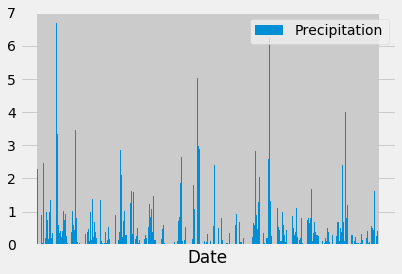

In [58]:
#create graph
fig, ax = plt.subplots()
plt.bar(x_axis,y_axis, label = "Precipitation")
#plt.axis('off')
plt.xlabel("Date")
plt.legend()
ax.tick_params(labelbottom=False)    
plt.show()

In [64]:
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [65]:
stations_count = session.query(Station).count()
print(f"There are {stations_count} stations.")

There are 9 stations.


In [66]:
#grab stations and group by to get number of instances
b=[]
c=[]
activity = session.query(Measurement).group_by(Measurement.station)
for x in activity: 
    b.append(x.station)
count = session.query(func.count(Measurement.id)).group_by(Measurement.station)
for x in count: 
    c.append(x)
a = []
for i in range(len(c)):
    a.append((c[i][0], b[i]))

In [67]:
# List the stations and the counts in descending order.
a.sort(reverse=True)
A = []
for i in range(len(a)):
    A.append((a[i][1], a[i][0]))
print(A)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [68]:
most_active_station = A[0][0]
active_rows = A[0][1]
print(f"Station {most_active_station} has the most rows (a total of {active_rows} rows) and is therefore the most active station.")

Station USC00519281 has the most rows (a total of 2772 rows) and is therefore the most active station.


In [69]:
#make query
tobs = session.query(Measurement.tobs).filter(Measurement.station == most_active_station)
#lowest temperature
tobs_low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station)
for i in tobs_low: 
    print(f"The lowest temperature on record for the most active station: {i[0]}.")
#highest temperature
tobs_high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station)
for i in tobs_high: 
    print(f"The highest temperature on record for the most active station: {i[0]}.")
#average temperature
tobs_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)
for i in tobs_avg: 
    print(f"The average temperature on record for the most active station: {i[0]}.")

The lowest temperature on record for the most active station: 54.0.
The highest temperature on record for the most active station: 85.0.
The average temperature on record for the most active station: 71.66378066378067.


In [70]:
#create station list
station_list = []
stations = session.query(Measurement).group_by(Measurement.station)
for i in stations: 
    if i.station not in station_list: 
        station_list.append(i.station)
for i in station_list: 
    print(i)

USC00511918
USC00513117
USC00514830
USC00516128
USC00517948
USC00518838
USC00519281
USC00519397
USC00519523


In [71]:
#make tobs query
tobs_query = session.query(Measurement.tobs)
#loop through the stations and find the amount of tobs data per station
tobs_data = []
for a in station_list: 
    count_check=0
    station=a
    station_filter = tobs_query.filter(Measurement.station == station)
    for i in station_filter:
        if i.tobs != np.isnan(i.tobs): 
            count_check+=1
    tobs_data.append((count_check, a))
#once all data is stored, sort list and pull out the station with the most data
sorted_list = sorted(tobs_data, reverse=True)
most_tobs = sorted_list[0][1]
print(most_tobs)

USC00519281


In [72]:
tobs_12months = session.query(Measurement).filter(Measurement.station == most_tobs).filter(Measurement.date> yearago)
date= []
tobs = []
for i in tobs_12months:
    date.append(i.date)
    tobs.append(i.tobs)

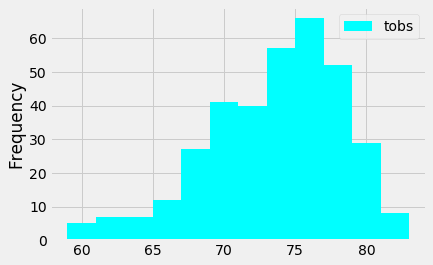

In [73]:
plt.hist(x=tobs, bins=12, color='cyan', label="tobs")
plt.legend()
plt.ylabel('Frequency')
plt.show()

Optional: Other Recommended Analyses

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    '''TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX'''
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [92]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# trip is in August 2018
trip_calc = calc_temps('2017-08-01', '2017-08-15')
trip_calc = [trip_calc[0][0], trip_calc[0][1], trip_calc[0][2]]

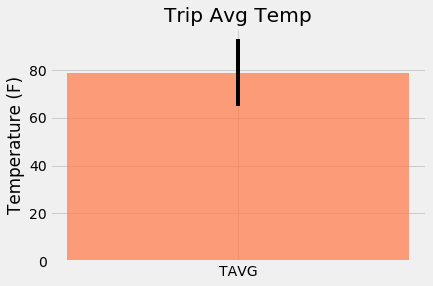

In [84]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
labels = ['TMIN', 'TAVG', 'TMAX']
plt.bar(labels[1], trip_calc[1], yerr = (trip_calc[2]-trip_calc[0]), color = 'coral', alpha = .75)
plt.title ('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.show()